In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.backend import clear_session
import gc

In [2]:
data = pd.read_csv('all_data_results_cleaned.csv')

In [3]:
to_drop=["pipe_dn","pipe_schedule","flange_class",
        "hot_spot_stress", "max_deformation", "support_right", "support_left", "ratio"]
to_keep=["outside_diameter", "wall_thickness", "raised_face_depth",
        "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius",
        "length1", "length2", "lumped_mass", "frequency", "x_deformation_position",
        "y_deformation_position", "z_deformation_position", "support", "allowable_deformation"]

data.drop(columns=to_drop,inplace=True)

In [4]:
numeric_features = ["outside_diameter", "wall_thickness", "raised_face_depth" ,'length1', 'length2', 'lumped_mass',
                    "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius"]
categorical_features = ['support']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ])

In [5]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [6]:
output_columns = ['allowable_deformation', 'frequency', 'x_deformation_position', 'y_deformation_position', 'z_deformation_position']
x = data.drop(output_columns, axis=1)
y = pd.DataFrame(data[output_columns])

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [8]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [9]:
scaler_y_frequency = StandardScaler()
scaler_y_allowable_deformation = StandardScaler()
scaler_y_x_position = StandardScaler()


#y_train_transformed_frequency = scaler_y_frequency.fit_transform(pd.DataFrame(y_train["frequency"]))
#y_test_transformed_frequency = scaler_y_frequency.transform(pd.DataFrame(y_test["frequency"]))

#y_train_transformed_allowable_deformation = scaler_y_allowable_deformation.fit_transform(pd.DataFrame(y_train["allowable_deformation"]))
#y_test_transformed_allowable_deformation = scaler_y_allowable_deformation.transform(pd.DataFrame(y_test["allowable_deformation"]))

y_train_transformed_x_position = scaler_y_x_position.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))
y_test_transformed_x_position = scaler_y_x_position.transform(pd.DataFrame(y_test["x_deformation_position"]))



In [10]:
logdir = "logs/x_position_measurements/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [11]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(512, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(128, activation='relu')(dropout1)


# Separate output for each target variable
output_layer = Dense(1)(hidden2)
#, name='allowable_deformation'


In [12]:
model = Model(inputs=input_layer, outputs=output_layer)

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,473 (287.00 KB)

 Trainable params: 73,473 (287.00 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='mse',
              metrics=["R2Score"])

In [15]:
history = model.fit(
    x_train_transformed, 
    y_train_transformed_x_position,  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - R2Score: 0.6658 - loss: 0.3264 - val_R2Score: 0.9432 - val_loss: 0.0551
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - R2Score: 0.9339 - loss: 0.0700 - val_R2Score: 0.9545 - val_loss: 0.0441
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - R2Score: 0.9548 - loss: 0.0454 - val_R2Score: 0.9562 - val_loss: 0.0424
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - R2Score: 0.9539 - loss: 0.0465 - val_R2Score: 0.9637 - val_loss: 0.0352
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - R2Score: 0.9602 - loss: 0.0400 - val_R2Score: 0.9649 - val_loss: 0.0341
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - R2Score: 0.9708 - loss: 0.0295 - val_R2Score: 0.9620 - val_loss: 0.0369
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - R2Score: 0.9717 - loss: 0.0289 - val_R2Score: 0.9732 - val_loss: 0.0260
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.9757 - loss: 0.0234 - val_R2Score: 0.9643 - v

In [16]:
test_loss, test_mse = model.evaluate(x_test_transformed, y_test_transformed_x_position)
print('Test accuracy:', test_mse)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - R2Score: 0.9879 - loss: 0.0110
Test accuracy: 0.9874218702316284


In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,421 (861.02 KB)

 Trainable params: 73,473 (287.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 146,948 (574.02 KB)

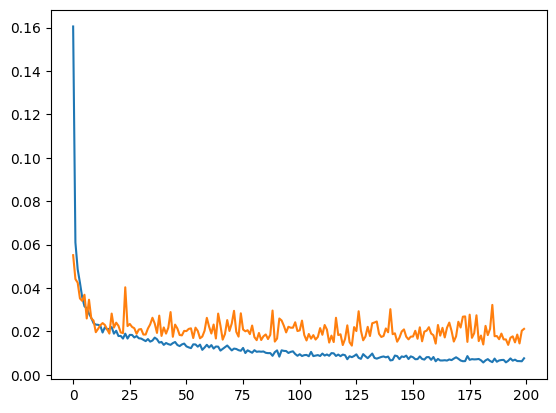

In [18]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")

In [19]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y_x_position.inverse_transform((predictions_scaled))

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [20]:
predictions_df = pd.DataFrame(predictions)
print("\nSample Predictions:")
print(predictions_df)


Sample Predictions:
                0
0    -1448.434082
1     -355.236603
2     -349.917053
3     -411.661682
4     -436.487152
...           ...
2452   190.635651
2453  -650.030457
2454    12.433740
2455   570.504761
2456   118.389671

[2457 rows x 1 columns]


In [21]:
y_test["x_deformation_position"]

524     -1475.60
10325    -393.11
11646    -321.76
10238    -366.40
10214    -466.69
          ...   
11507     202.29
2709     -678.75
12218     -57.20
2858      584.12
9935       28.40
Name: x_deformation_position, Length: 2457, dtype: float64

In [22]:
true= y_test["x_deformation_position"].tolist()
pred= predictions_df[0].tolist()
mean_squared_error(true,pred)

29477.725163743537

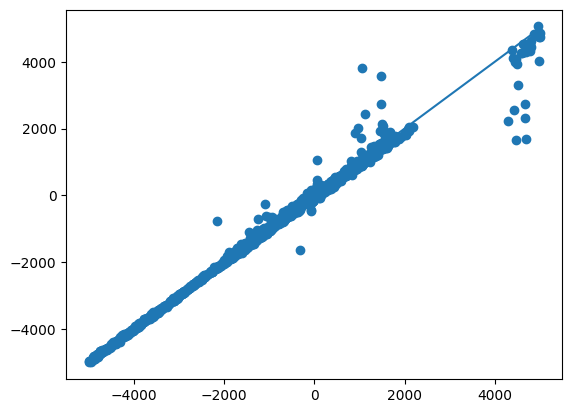

In [27]:
pred=predictions_df
ansys=y_test["x_deformation_position"]
plt.scatter(ansys,pred)
#plt.loglog()
plt.plot([-5000, 5000],[-5000, 5000])
plt.show()

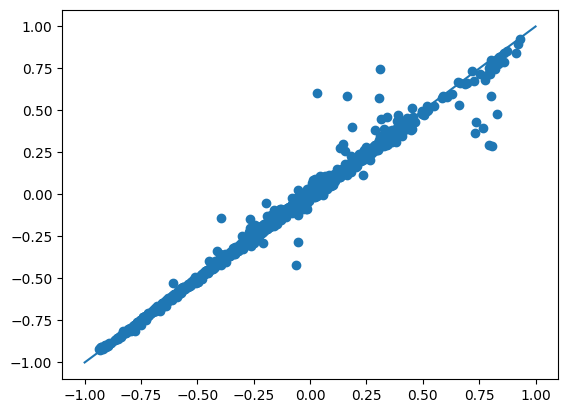

0.9861726104501978

In [51]:
length = x_test["length1"]+x_test["length2"]

ansys=y_test["x_deformation_position"]/length
length = pd.DataFrame(length)
length.reset_index(drop=True,inplace=True)

pred=predictions_df/length

plt.scatter(ansys,pred)
#plt.loglog()
plt.plot([-1, 1],[-1, 1])
plt.show()

mean_squared_error(ansys,pred)
r2_score(ansys,pred)

In [63]:
x_test["length1"]

524       664.0
10325    3847.0
11646    4475.0
10238    2463.0
10214    2353.0
          ...  
11507    2122.0
2709     3084.0
12218    1236.0
2858     4412.0
9935     3412.0
Name: length1, Length: 2457, dtype: float64

In [64]:
y_test["x_deformation_position"]

524     -1475.60
10325    -393.11
11646    -321.76
10238    -366.40
10214    -466.69
          ...   
11507     202.29
2709     -678.75
12218     -57.20
2858      584.12
9935       28.40
Name: x_deformation_position, Length: 2457, dtype: float64

In [124]:
#Scale Between 0 and 1
x_postion = x_test["length2"]+y_test["x_deformation_position"]
length = x_test["length1"]+x_test["length2"]

position_ratio = x_postion/length

length = pd.DataFrame(length)
length.reset_index(drop=True,inplace=True)
length2=x_test["length2"]
length2 = pd.DataFrame(length2)
length2.reset_index(drop=True,inplace=True)

x_postion_pred = predictions_df[0]+length2["length2"]
position_ratio_pred = x_postion_pred/length[0]


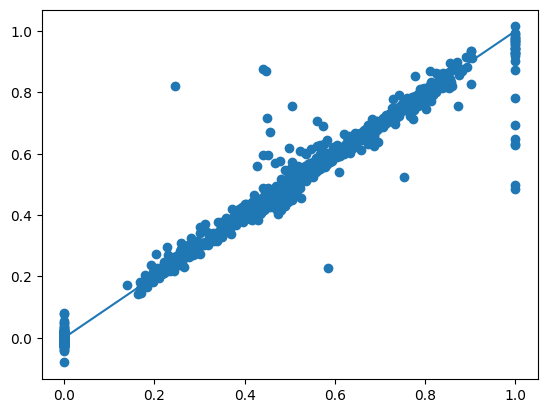

0.9830207016517108

In [129]:
plt.scatter(position_ratio,position_ratio_pred)
#plt.loglog()
plt.plot([0, 1],[0, 1])
plt.show()

mean_squared_error(position_ratio,position_ratio_pred)
r2_score(position_ratio,position_ratio_pred)

In [24]:
clear_session()
del model
gc.collect()

0

In [25]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          data:  2.1 MiB
                             x:  1.6 MiB
                       x_train:  1.4 MiB
           x_train_transformed:  1.0 MiB
                             y: 480.0 KiB
                       y_train: 460.7 KiB
                        x_test: 356.4 KiB
            x_test_transformed: 268.9 KiB
                        y_test: 115.2 KiB
y_train_transformed_x_position: 76.9 KiB
